# 1.Imports

In [121]:
import re
import yaml
import torch
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from scipy.io import wavfile
import matplotlib.pyplot as plt

from asteroid.models import ConvTasNet
from asteroid.data import MUSDB18Dataset

In [122]:
DATA_DIR = Path("musdb_data")

TEST_SONG = DATA_DIR/"test/Al James - Schoolboy Facination.stem.mp4"

TRAINING_DIR = Path('weights')/"training_20220304-180134"

cfg_path = TRAINING_DIR/"cfg.yaml"
history_path = TRAINING_DIR/"history.csv"

model_paths = sorted(list(TRAINING_DIR.glob("model_*")), key=lambda x: int("".join(re.findall(r"\d", str(x)))))

with open(str(cfg_path), 'r') as file:
    CFG = yaml.load(file, Loader=yaml.FullLoader)

assert cfg_path.exists() and history_path.exists() and cfg_path.exists()

## Hyper parameters:

In [123]:
for key, value in CFG.items():
    print(f">>> {key.upper()} -> {value}")

>>> SAMPLE_RATE -> 44100
>>> SIZE -> -1
>>> LEARNING_RATE -> 0.001
>>> N_EPOCHS -> 10
>>> BATCH_SIZE -> 64
>>> SEGMENT_SIZE -> 1
>>> RANDOM_TRACK_MIX -> False
>>> TARGETS -> ['drums', 'bass', 'other', 'vocals']
>>> N_BLOCKS -> 8
>>> N_REPEATS -> 3
>>> BN_CHAN -> 128
>>> HID_CHAN -> 512
>>> SKIP_CHAN -> 128
>>> CONV_KERNEL_SIZE -> 3
>>> KERNEL_SIZE -> 16
>>> N_FILTERS -> 512
>>> STRIDE -> 8
>>> LOSS -> pairwise_mse
>>> STORE_GRADIENT_NORM -> True
>>> VERBOSE -> 1


# 2. Learning Curves

In [124]:
df = pd.read_csv(history_path)
epochs = df.index.values
train_loss = df.train_loss
val_loss = df.val_loss

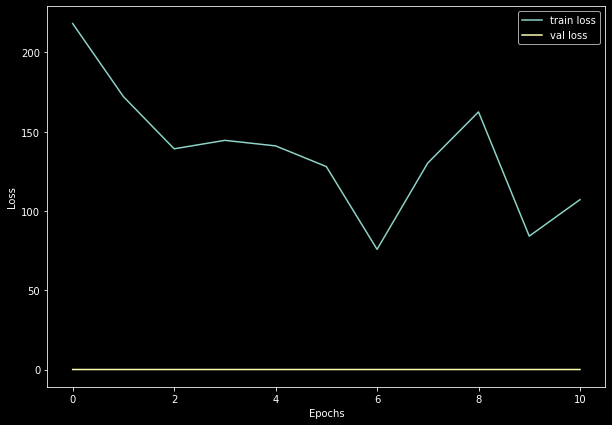

In [125]:
plt.figure(figsize=(10, 7))
plt.plot(epochs, train_loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.plot();

## Observations :
- The model does not learn ! Instability ?
  - Solutions ?:
    - Reduce learning rate
    - Increase batch size
    - Store the learning rate at each epoch
    - Store other metrics
    - Store gradients norms

<br/>

- Maybe use smaller network ?

# 3. Load model

In [126]:
SAMPLE_RATE = CFG["sample_rate"]
TARGETS = CFG["targets"]
N_SRC = len(TARGETS)
N_BLOCKS = CFG["n_blocks"]
N_REPEATS = CFG["n_repeats"]
BN_CHAN = CFG["bn_chan"]
HID_CHAN = CFG["hid_chan"]
SKIP_CHAN = CFG["skip_chan"]
CONV_KERNEL_SIZE = CFG["conv_kernel_size"]
KERNEL_SIZE = CFG["kernel_size"]
N_FILTERS = CFG["n_filters"]
STRIDE = CFG["stride"]

In [127]:
TARGETS

['drums', 'bass', 'other', 'vocals']

In [128]:
models = list()
for mp in model_paths:
    model = ConvTasNet(
        n_src=N_SRC,
        sample_rate=SAMPLE_RATE,
        n_blocks=N_BLOCKS,
        n_repeats=N_REPEATS,
        bn_chan=BN_CHAN,
        hid_chan=HID_CHAN,
        skip_chan=SKIP_CHAN,
        conv_kernel_size=CONV_KERNEL_SIZE,
        norm_type="gLN",
        mask_act="sigmoid",
        kernel_size=KERNEL_SIZE,
        n_filters=N_FILTERS,
        stride=STRIDE
    )
    model.load_state_dict(torch.load(mp)["model_state_dict"])
    models.append(model)

def compare_weights(model1, model2):
    diffs = {}
    for m1, m2 in zip(model1.state_dict().items(), model2.state_dict().items()):
        diffs[m1[0]] = torch.mean(m1[1] - m2[1])
    return diffs

In [129]:
compare_weights(models[0], models[-1])

{'encoder.filterbank._filters': tensor(0.0004),
 'masker.bottleneck.0.gamma': tensor(0.0004),
 'masker.bottleneck.0.beta': tensor(0.0002),
 'masker.bottleneck.1.weight': tensor(1.4712e-05),
 'masker.bottleneck.1.bias': tensor(-0.0003),
 'masker.TCN.0.shared_block.0.weight': tensor(-3.1425e-06),
 'masker.TCN.0.shared_block.0.bias': tensor(0.0005),
 'masker.TCN.0.shared_block.1.weight': tensor(0.0105),
 'masker.TCN.0.shared_block.2.gamma': tensor(6.0278e-05),
 'masker.TCN.0.shared_block.2.beta': tensor(4.1069e-05),
 'masker.TCN.0.shared_block.3.weight': tensor(0.0002),
 'masker.TCN.0.shared_block.3.bias': tensor(-1.9525e-05),
 'masker.TCN.0.shared_block.4.weight': tensor(0.0113),
 'masker.TCN.0.shared_block.5.gamma': tensor(-0.0003),
 'masker.TCN.0.shared_block.5.beta': tensor(-0.0002),
 'masker.TCN.0.res_conv.weight': tensor(1.3759e-05),
 'masker.TCN.0.res_conv.bias': tensor(-0.0004),
 'masker.TCN.0.skip_conv.weight': tensor(-5.7355e-05),
 'masker.TCN.0.skip_conv.bias': tensor(0.0004),


# 4. Separation test

In [11]:
sound, sr = librosa.load(TEST_SONG.__str__(), sr=SAMPLE_RATE)

/Users/alexandre/opt/anaconda3/envs/IA321_env/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [12]:
sound = torch.tensor(sound[:10 * SAMPLE_RATE])

In [13]:
pred = model(sound)

In [14]:
pred.shape

torch.Size([4, 441000])

In [16]:
for i, name in enumerate(TARGETS):
    wavfile.write(f"./{name}.wav", SAMPLE_RATE, pred[i].detach().numpy())